# Subject: Advanced Data Analysis

# Module: Geospatial Analysis

## Session 3 - Open data and Crowdsourcing smart geoforms

### Demo 1 -  Visualize your Google location history

Visit https://takeout.google.com/settings/takeout to download your Google location history as a JSON file called LocationHistory.json.

# 1. Convert JSON to OGC shapefile

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime as dt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
# load the google location history data
df_gps = pd.read_json('LocationHistory.json')
print('There are {:,} rows in the location history dataset'.format(len(df_gps)))

There are 387,317 rows in the location history dataset


In [3]:
# parse lat, lon, and timestamp from the dict inside the locations column
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp_ms'] = df_gps['locations'].map(lambda x: x['timestampMs'])

# convert lat/lon to decimalized degrees and the timestamp to date-time
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7
df_gps['timestamp_ms'] = df_gps['timestamp_ms'].astype(float) / 1000
df_gps['datetime'] = df_gps['timestamp_ms'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
date_range = '{}-{}'.format(df_gps['datetime'].min()[:4], df_gps['datetime'].max()[:4])

In [4]:
# drop columns we don't need, then show a slice of the dataframe
df_gps = df_gps.drop(labels=['locations', 'timestamp_ms'], axis=1, inplace=False)
#df_gps[1000:1005]

In [6]:
type(df_gps)

pandas.core.frame.DataFrame

In [8]:
df_gps.head()

,lat,lon,datetime
0,41.406273,2.185852,2018-01-11 17:14:46
1,41.405085,2.201500,2018-01-11 17:11:31
2,41.405085,2.201499,2018-01-11 17:11:15
3,41.405085,2.201499,2018-01-11 17:10:59
4,41.405085,2.201499,2018-01-11 17:10:43


In [7]:
import geopandas as gpd

In [9]:
from shapely.geometry import Point

# combine lat and lon column to a shapely Point() object
df_gps['geometry'] = df_gps.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)

In [10]:
df_gps2 = gpd.GeoDataFrame(df_gps, geometry='geometry')

In [11]:
type(df_gps2)

geopandas.geodataframe.GeoDataFrame

In [12]:
# proj WGS84

df_gps2.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

In [13]:
df_gps2.to_file('df_gps_Francisco.shp', driver='ESRI Shapefile')

# 2. Now map the entire dataset (approx 387 thousand points)

In [14]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

C:\Users\francisco.sacramento\AppData\Local\Continuum\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


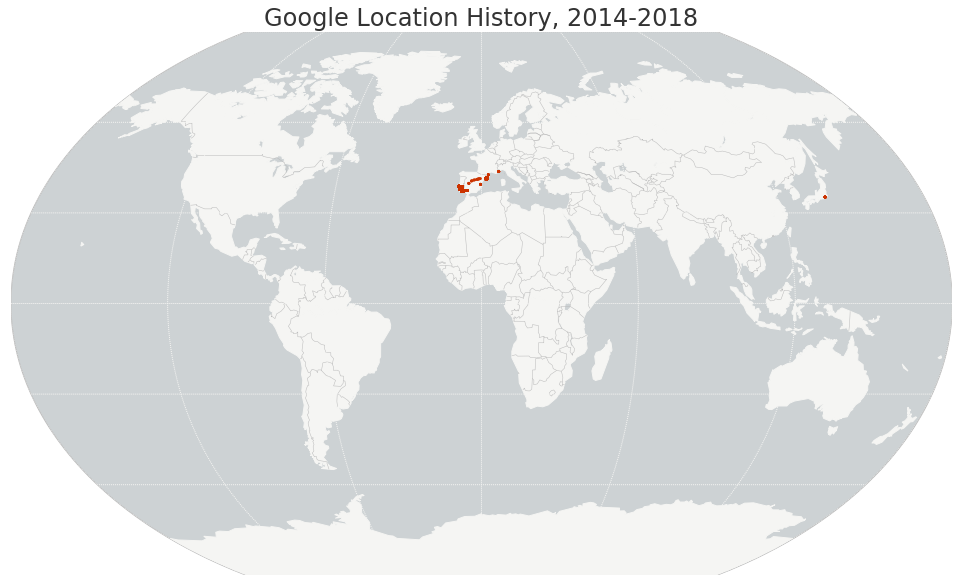

In [15]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#ffffff', frame_on=False)
ax.set_title('Google Location History, {}'.format(date_range), fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project the location history points then scatter plot them
x, y = m(df_gps['lon'].values, df_gps['lat'].values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('google_location_history_world_map.png', dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()